In [1]:
## new classification model
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
from math import ceil
import seaborn as sns
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import optimizers
import tensorflow.keras.models as models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16, vgg19, resnet, inception_v3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(123)
%matplotlib inline

In [2]:
def fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                          img_dim = (250, 250)):
    start = time()
    print('Fetching data...')

    files = glob.glob('{}training-image/*.png'.format(data_dir))
    benign_train = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_train = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign training images: {len(benign_train)}\nmalignant training images: {len(malignant_train)}')
    
    files = glob.glob('{}test-image/*.png'.format(data_dir))
    benign_test = np.array([fn for fn in files if 'benign' in fn.lower()])
    malignant_test = np.array([fn for fn in files if 'malignant' in fn.lower()])
    print(f'benign test images: {len(benign_test)}\nmalignant test images: {len(malignant_test)}')
    
    print('\nBenign datasets:', benign_train.shape, benign_test.shape)
    print('Malignant datasets:', malignant_train.shape, malignant_test.shape)
    
    print('\nMoving data into sub-directories if necessary...')
    train_dir = '{}training_image_data'.format(data_dir)
    test_dir = '{}test_image_data'.format(data_dir)

    train_files = np.concatenate([benign_train, malignant_train])
    test_files = np.concatenate([benign_test, malignant_test])

    if os.path.isdir(train_dir):
        if len(os.listdir(train_dir)) > 1:
            print('    Training data already in correct directory')
        else:
            for fn in train_files:
                shutil.copy(fn, train_dir)
            print('    Training data moved')
    else:
        os.mkdir(train_dir)
        for fn in train_files:
                shutil.copy(fn, train_dir)
        print('    Training data moved')

    if os.path.isdir(test_dir):
        if len(os.listdir(test_dir)) > 1:
            print('    Test data already in correct directory')
        else:
            for fn in test_files:
                shutil.copy(fn, test_dir)
            print('    Test data moved')
    else:
        os.mkdir(test_dir)
        for fn in test_files:
                shutil.copy(fn, test_dir)
        print('    Test data moved')
    
    # train
    print('\nTransfering training images to arrays of dimension {}...'.format(img_dim))
    train_files = glob.glob('{}/*'.format(train_dir))
    train_imgs = []
    for img in train_files:
        if not img.endswith('.png'):
            continue
        im = cv2.imread(img, cv2.IMREAD_COLOR)
        x = cv2.resize(im, (img_dim[1], img_dim[0]))
        train_imgs += [x]
    train_imgs = np.array(train_imgs)
    train_labels = [fn.split('/')[-1].split('_')[-1].replace('.png','').lower().strip() for fn in train_files]

    print('Train dataset shape:', train_imgs.shape)
    
    train_imgs_scaled = train_imgs.astype(np.float32)
    train_imgs_scaled /= 255

    
    input_shape = (img_dim[1], img_dim[0], 3)
    le = LabelEncoder()
    le.fit(train_labels)
    train_labels_enc = le.transform(train_labels)

    # test
    print('\nTransfering test images to arrays of dimension {}...'.format(img_dim))
    test_files = glob.glob('{}/*.png'.format(test_dir))
    test_imgs = []
    for img in test_files:
        if not img.endswith('.png'):
            continue
        im = cv2.imread(img, cv2.IMREAD_COLOR)
        x = cv2.resize(im, (img_dim[1], img_dim[0]))
        test_imgs += [x]       
    test_imgs = np.array(test_imgs)
    test_labels = [fn.split('/')[-1].split('_')[-1].replace('.png','').lower().strip() for fn in test_files]

    print('Train dataset shape:', test_imgs.shape)
    
    test_imgs_scaled = test_imgs.astype(np.float32)
    test_imgs_scaled /= 255
    
    input_shape = (img_dim[0], img_dim[1], 3)
    test_labels_enc = le.transform(test_labels)
    
    end = time()
    elapsed = (end - start)/60
    print('\nData processing time is %f minutes.' % elapsed)
    
    return train_imgs, train_imgs_scaled, train_labels_enc, test_imgs, test_imgs_scaled, test_labels_enc, input_shape


In [3]:
# process data
train_imgs, train_imgs_scaled, train_labels_enc, test_imgs, test_imgs_scaled, test_labels_enc, input_shape = fetch_preprocess_data(data_dir = '/Users/jacksimonson/Springboard_Work/data/',
                                                                                                            img_dim = (1000, 500))

Fetching data...
benign training images: 1040
malignant training images: 1113
benign test images: 307
malignant test images: 264

Benign datasets: (1040,) (307,)
Malignant datasets: (1113,) (264,)

Moving data into sub-directories if necessary...
    Training data already in correct directory
    Test data already in correct directory

Transfering training images to arrays of dimension (1000, 500)...
Train dataset shape: (2153, 1000, 500, 3)

Transfering test images to arrays of dimension (1000, 500)...
Train dataset shape: (571, 1000, 500, 3)

Data processing time is 8.605223 minutes.


Example train image


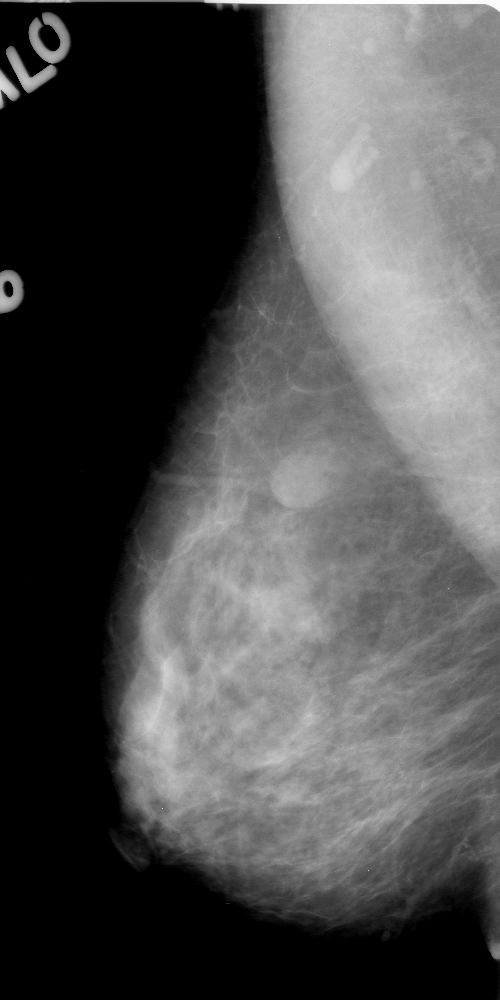

In [4]:
print(f'Example train image')
array_to_img(train_imgs[0])

### Vanilla CNN

In [5]:
def vanilla_cnn(batch_size = 30, num_classes = 2, epochs = 30, train_steps = 10, val_steps = 5,
                validation_split = 0.2, loss='binary_crossentropy', 
                metrics=['accuracy'], optimizer = optimizers.RMSprop(lr = 1e-4),
                train_batch_size = 30, val_batch_size = 20, augment = False,
                train_imgs_scaled = None, train_labels_enc = None, input_shape = None,
                train_imgs = None, model_path = '/Users/jacksimonson/Springboard_Work'):
    
    start = time()
    
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(loss = loss,
                  optimizer=optimizer,
                  metrics=metrics)

    print(model.summary())
    
    if augment:
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                           horizontal_flip=True, fill_mode='nearest', validation_split = validation_split)

        train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
        val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
        
        history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
                            validation_data=val_generator, validation_steps=val_steps, 
                            verbose=1)
    else:
        history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                            validation_split = validation_split,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)        
        
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if augment:
        t = f.suptitle('Basic CNN with Augmentation', fontsize=12)
    else:
        t = f.suptitle('Basic CNN', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    if augment:
        model_file_path = f'{model_path}/vanilla_cnn_model_with_augmentation.h5'
        model.save(model_file_path)
    else:
        model_file_path = f'{model_path}/vanilla_cnn_model.h5'
        model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
    if augment:
        print('Vanilla CNN with augmentation train time is %f minutes.' % elapsed)
    else:
        print('Vanilla CNN train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

### Vanilla CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 998, 498, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 499, 249, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 497, 247, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 248, 123, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 246, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 60, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 58, 128)      1

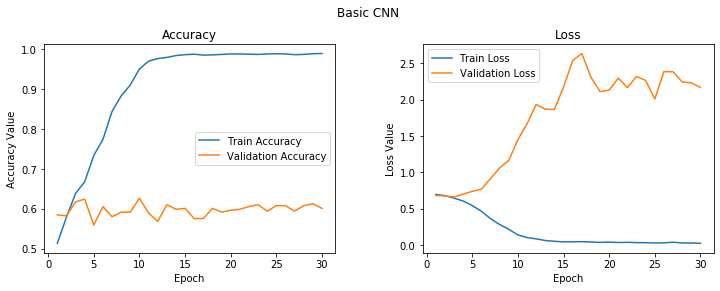

In [6]:
vanilla_model, vanilla_history, vanilla_f, (vanilla_ax1, vanilla_ax2), vanilla_model_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                             input_shape = input_shape,
                                                                                                             train_imgs = train_imgs)

### Vanilla CNN with Augmentation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 998, 498, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 499, 249, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 497, 247, 64)      9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 248, 123, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 246, 121, 128)     73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 60, 128)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 121, 58, 128)     

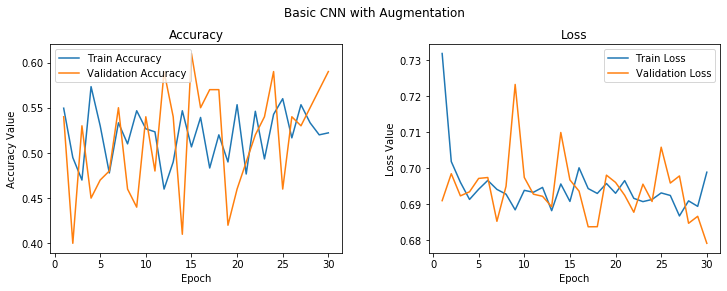

In [7]:
vanilla_model_augment, vanilla_history_augment, vanilla_f_augment, (vanilla_ax1_augment, vanilla_ax2_augment), vanilla_model_augment_file_path = vanilla_cnn(train_imgs_scaled = train_imgs_scaled,
                                                                                                                                                             train_labels_enc = train_labels_enc,
                                                                                                                                                             input_shape = input_shape,
                                                                                                                                                             train_imgs = train_imgs,
                                                                                                                                                             augment = True)

### Transfer Learning

In [ ]:
# function to fit and train classifier
def run_transfer_classification(in_model = None, model_name = None, epochs = 25, train_steps = 10,
                                val_steps = 5, train_layers = [],
                                metrics=['accuracy'], validation_split = 0.2, train_batch_size = 30,
                                val_batch_size = 20, loss='binary_crossentropy', augment = False,
                                optimizer = optimizers.RMSprop(lr=1e-5),
                                model_path = '/Users/jacksimonson/Springboard_Work',
                                train_imgs_scaled = None, train_labels_enc = None,
                                input_imgs = None):
    
    start = time()
    
    if in_model is None:
        raise Exception('Please specify a model')

    output = in_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    _model = Model(in_model.input, output)
    _model.trainable = True

    set_trainable = False
    for layer in _model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
    print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    input_shape = _model.output_shape[1]

    model = Sequential()
    model.add(_model)
    model.add(Dense(512, activation='relu', input_dim=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])

    print(model.summary())
    
#     if augment:
#         train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
#                                            width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
#                                            horizontal_flip=True, fill_mode='nearest',
#                                            validation_split = validation_split)

#         train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=train_batch_size)
#         val_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=val_batch_size)
    
#         history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs,
#                             validation_steps=val_steps, validation_data=val_generator,
#                             verbose=1)
#     else:
    history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                        validation_split = validation_split,
                        batch_size=train_batch_size,
                        epochs=epochs,
                        verbose=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs + 1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

#     if augment:
#         model_file_path = f'{model_path}/{model_name}_transfer_with_augmentation_model.h5'
#         model.save(model_file_path)
#     else:
    model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
    model.save(model_file_path)
    
    end = time()
    elapsed = (end - start)/60
#     if augment:
#         print(f'{model_name} with augmentation train time is %f minutes.' % elapsed)
#     else:
    print(f'{model_name} train time is %f minutes.' % elapsed)
    
    return model, history, f, (ax1, ax2), model_file_path

#### Get Models

In [8]:
# get models
models = {}
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
resnet_model = resnet.ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
inception_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

models = {'VGG16': (vgg16_model, False, ['block5_conv1', 'block4_conv1']),
          'VGG19': (vgg19_model, False, ['block5_conv1', 'block4_conv1']),
          'ResNet': (resnet_model, False, ['conv5_block2_1_conv']),
          'Inception': (inception_model, False, ['conv2d_83'])}

#### Run Transfer Learning

In [ ]:
# run classifier

# optimizer = optimizers.AdamOptimizer(lr=learning_rate) #optimizers.RMSprop(lr=1e-4)
# transfer_results = {}
# for model_name, tup in models.items():
#     in_model, augment, train_layers = tup
#     out_model, history, f, (ax1, ax2), model_file_path = run_transfer_classification(in_model = in_model,
#                                                                                      model_name = model_name,
#                                                                                      train_imgs_scaled = train_imgs_scaled,
#                                                                                      input_imgs = train_imgs,
#                                                                                      train_layers = train_layers)
#     transfer_results[model_name] = (out_model, history, f, (ax1, ax2), model_file_path)

In [9]:
transfer_results = {}

                                            Layer Type           Layer Name  \
0    <tensorflow.python.keras.engine.input_layer.In...              input_3   
1    <tensorflow.python.keras.layers.convolutional....            conv1_pad   
2    <tensorflow.python.keras.layers.convolutional....           conv1_conv   
3    <tensorflow.python.keras.layers.normalization_...             conv1_bn   
4    <tensorflow.python.keras.layers.core.Activatio...           conv1_relu   
..                                                 ...                  ...   
341  <tensorflow.python.keras.layers.convolutional....  conv5_block3_3_conv   
342  <tensorflow.python.keras.layers.normalization_...    conv5_block3_3_bn   
343  <tensorflow.python.keras.layers.merge.Add obje...     conv5_block3_add   
344  <tensorflow.python.keras.layers.core.Activatio...     conv5_block3_out   
345  <tensorflow.python.keras.layers.core.Flatten o...            flatten_2   

     Layer Trainable  
0              False  
1    

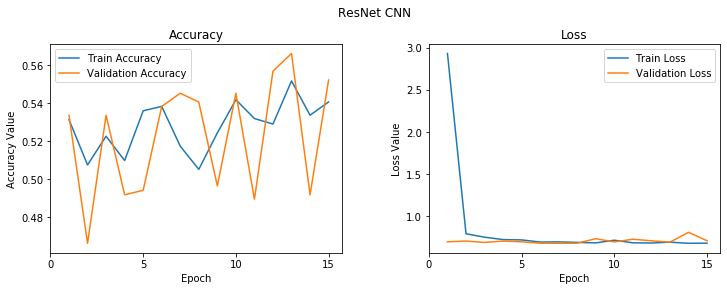

In [10]:
start = time()

in_model = resnet_model
model_name = 'ResNet'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['conv5_block2_1_conv']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
transfer_results[model_name] = (model, history, model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                           Layer Type    Layer Name  \
0   <tensorflow.python.keras.engine.input_layer.In...       input_2   
1   <tensorflow.python.keras.layers.convolutional....  block1_conv1   
2   <tensorflow.python.keras.layers.convolutional....  block1_conv2   
3   <tensorflow.python.keras.layers.pooling.MaxPoo...   block1_pool   
4   <tensorflow.python.keras.layers.convolutional....  block2_conv1   
5   <tensorflow.python.keras.layers.convolutional....  block2_conv2   
6   <tensorflow.python.keras.layers.pooling.MaxPoo...   block2_pool   
7   <tensorflow.python.keras.layers.convolutional....  block3_conv1   
8   <tensorflow.python.keras.layers.convolutional....  block3_conv2   
9   <tensorflow.python.keras.layers.convolutional....  block3_conv3   
10  <tensorflow.python.keras.layers.convolutional....  block3_conv4   
11  <tensorflow.python.keras.layers.pooling.MaxPoo...   block3_pool   
12  <tensorflow.python.keras.layers.convolutional....  block4_conv1   
13  <t

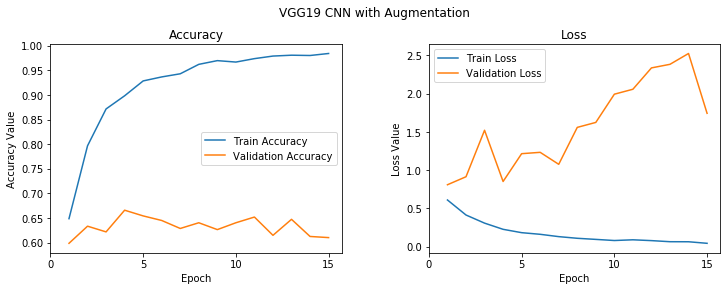

In [13]:
start = time()

in_model = vgg19_model
model_name = 'VGG19'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['block5_conv1', 'block4_conv1']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True

set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    

t = f.suptitle('{} CNN with Augmentation'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
    
transfer_results[model_name] = (model, history, model_file_path)

end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

                                            Layer Type           Layer Name  \
0    <tensorflow.python.keras.engine.input_layer.In...              input_4   
1    <tensorflow.python.keras.layers.convolutional....             conv2d_8   
2    <tensorflow.python.keras.layers.normalization_...  batch_normalization   
3    <tensorflow.python.keras.layers.core.Activatio...           activation   
4    <tensorflow.python.keras.layers.convolutional....             conv2d_9   
..                                                 ...                  ...   
307  <tensorflow.python.keras.layers.merge.Concaten...             mixed9_1   
308  <tensorflow.python.keras.layers.merge.Concaten...        concatenate_1   
309  <tensorflow.python.keras.layers.core.Activatio...        activation_93   
310  <tensorflow.python.keras.layers.merge.Concaten...              mixed10   
311  <tensorflow.python.keras.layers.core.Flatten o...            flatten_6   

     Layer Trainable  
0              False  
1    

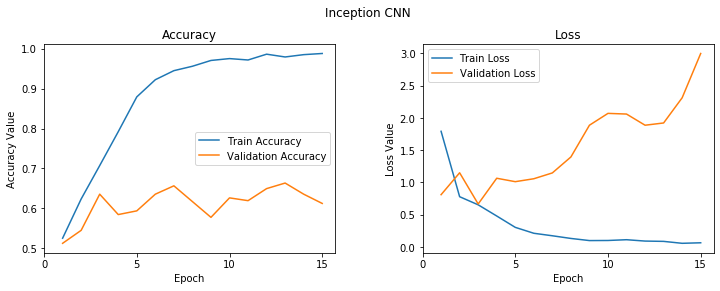

In [14]:
start = time()

in_model = inception_model
model_name = 'Inception'
epochs = 15
train_steps = 10
val_steps = 5
train_layers = ['conv2d_83']
metrics=['accuracy']
validation_split = 0.2
train_batch_size = 30
val_batch_size = 20
loss='binary_crossentropy'
augment = False
model_path = '/Users/jacksimonson/Springboard_Work'
output = in_model.layers[-1].output
output = keras.layers.Flatten()(output)
_model = Model(in_model.input, output)
_model.trainable = True


set_trainable = False
for layer in _model.layers:
    if layer.name in train_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in _model.layers]
print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

input_shape = _model.output_shape[1]

model = Sequential()
model.add(_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

print(model.summary())
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_split = validation_split,
                    batch_size=train_batch_size,
                    epochs=epochs,
                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
t = f.suptitle('{} CNN'.format(model_name), fontsize=12)

f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs + 1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


model_file_path = f'{model_path}/{model_name}_transfer_model.h5'
model.save(model_file_path)
    
transfer_results[model_name] = (model, history, model_file_path)
    
end = time()
elapsed = (end-start)/60

print(f'{model_name} train time is %f minutes.' % elapsed)

### Test Models

In [15]:
def test_models(model_file_path = None, test_labels_enc = None, test_imgs = None):
    if model_file_path is None:
        raise Exception('Specify a model file path')
    
    print('loading model...')
    model = keras.models.load_model(model_file_path)
    print('loaded {}'.format(model_file_path.replace('.h5', '').split('/')[-1].replace('_', ' ').title()))
    
    y_pred = model.predict_classes(test_imgs, verbose=1)
    con_mat = tf.math.confusion_matrix(labels = test_labels_enc, predictions = y_pred).numpy()
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df_norm = pd.DataFrame(con_mat_norm,
                              index = ['Benign', 'Malignant'], 
                              columns = ['Benign', 'Malignant'])

    con_mat_df = pd.DataFrame(con_mat,
                              index = ['Benign', 'Malignant'], 
                              columns = ['Benign', 'Malignant'])

    tp = con_mat_df['Malignant'][1]
    tn = con_mat_df['Benign'][0]
    fp = con_mat_df['Benign'][1]
    fn = con_mat_df['Malignant'][0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fn_rate = fn / (fn+tp)
    fp_rate = tn / (tn+fp)
    f1 = 2 * ((precision*recall) / (precision+recall))
    
    print('\nTrue Positive: {}'.format(tp))
    print('False Positive: {}'.format(fp))
    print('True Negative: {}'.format(tn))
    print('False Negative: {}\n'.format(fn))

    print('Accuracy: {:.3f}'.format((tp+tn)/len(y_pred)))
    print('Precision: {:.3f}'.format(precision))
    print('Recall: {:.3f}'.format(recall))
    print('F-score: {:.3f}'.format(f1))
    print('False Negative Rate: {:.3f}'.format(fn_rate))
    print('False Positive Rate: {:.3f}'.format(fp_rate))
    print('True Negative Rate: {:.3f}'.format(1-fp_rate))
    print('True Positive Rate: {:.3f}'.format(1 - fn_rate))

    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df_norm, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.title(model_file_path.replace('.h5', '').split('/')[-1].replace('_', ' ').title())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds_keras = roc_curve(test_labels_enc, y_pred)
    auc = auc(fpr, tpr)

    return (fpr, tpr, auc)

loading model...
loaded Vanilla Cnn Model
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
18/18 [==============================] - 21s 1s/step

True Positive: 163
False Positive: 101
True Negative: 168
False Negative: 139

Accuracy: 0.580
Precision: 0.617
Recall: 0.540
F-score: 0.576
False Negative Rate: 0.460
False Positive Rate: 0.625
True Negative Rate: 0.375
True Positive Rate: 0.540


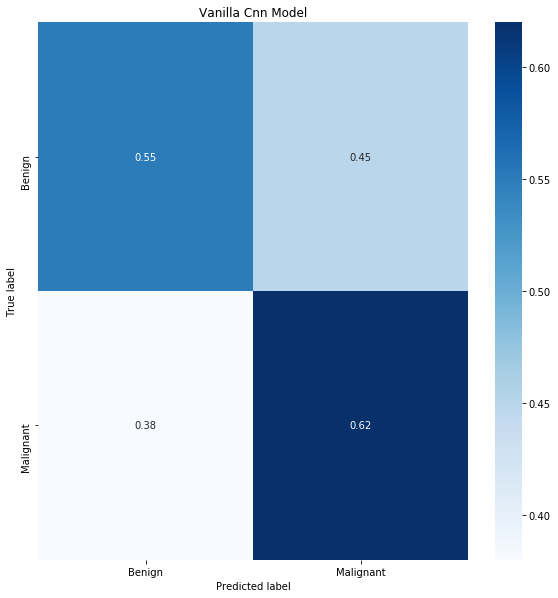

loading model...
loaded Vanilla Cnn Model With Augmentation
18/18 [==============================] - 18s 1s/step

True Positive: 253
False Positive: 11
True Negative: 8
False Negative: 299

Accuracy: 0.457
Precision: 0.958
Recall: 0.458
F-score: 0.620
False Negative Rate: 0.542
False Positive Rate: 0.421
True Negative Rate: 0.579
True Positive Rate: 0.458


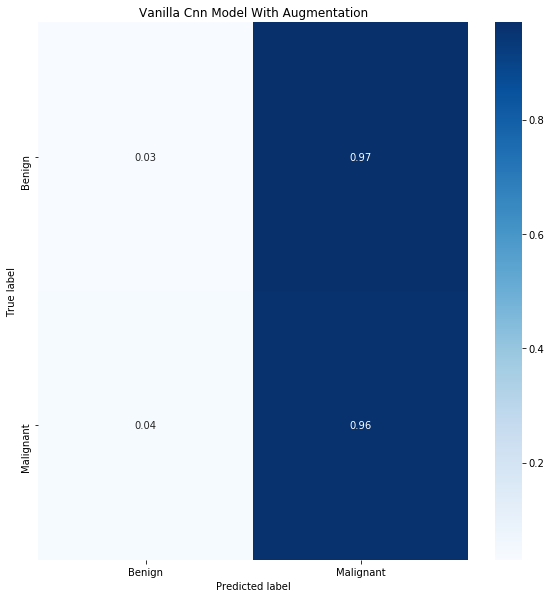

loading model...
loaded Resnet Transfer Model
18/18 [==============================] - 249s 14s/step

True Positive: 248
False Positive: 16
True Negative: 14
False Negative: 293

Accuracy: 0.459
Precision: 0.939
Recall: 0.458
F-score: 0.616
False Negative Rate: 0.542
False Positive Rate: 0.467
True Negative Rate: 0.533
True Positive Rate: 0.458


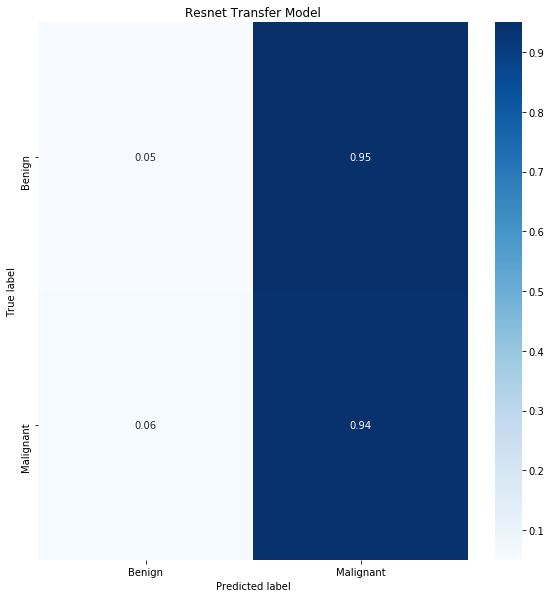

loading model...
loaded Vgg19 Transfer Model
18/18 [==============================] - 428s 24s/step

True Positive: 153
False Positive: 111
True Negative: 205
False Negative: 102

Accuracy: 0.627
Precision: 0.580
Recall: 0.600
F-score: 0.590
False Negative Rate: 0.400
False Positive Rate: 0.649
True Negative Rate: 0.351
True Positive Rate: 0.600


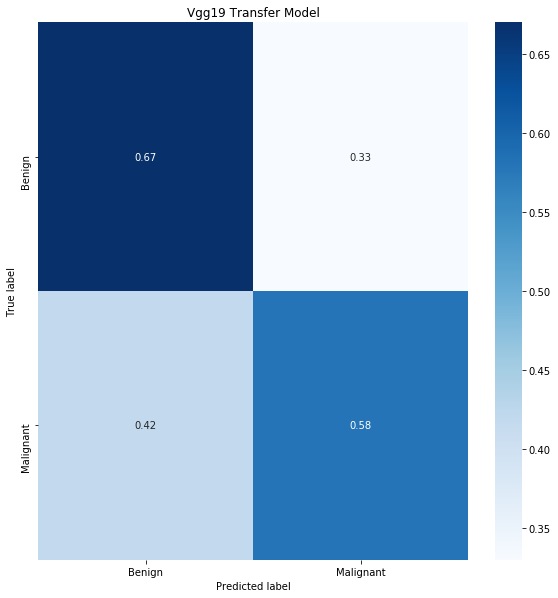

loading model...
loaded Inception Transfer Model
18/18 [==============================] - 95s 5s/step

True Positive: 225
False Positive: 39
True Negative: 107
False Negative: 200

Accuracy: 0.581
Precision: 0.852
Recall: 0.529
F-score: 0.653
False Negative Rate: 0.471
False Positive Rate: 0.733
True Negative Rate: 0.267
True Positive Rate: 0.529


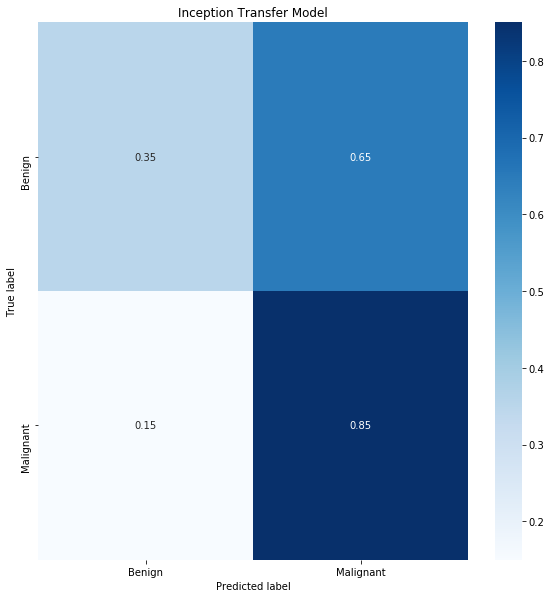

In [16]:
base_dir = '/Users/jacksimonson/Springboard_Work'

models = {'{}/vanilla_cnn_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/vanilla_cnn_model_with_augmentation.h5'.format(base_dir): test_imgs_scaled,
          '{}/ResNet_transfer_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/VGG19_transfer_model.h5'.format(base_dir): test_imgs_scaled,
          '{}/Inception_transfer_model.h5'.format(base_dir): test_imgs_scaled}

roc_auc_info = {}
for model_file_path, imgs in models.items():
    model_name = model_file_path.split('/')[-1].replace('.h5','').replace('_', ' ')
    roc_auc_info[model_name] = test_models(model_file_path = model_file_path, test_labels_enc = test_labels_enc, test_imgs = imgs)

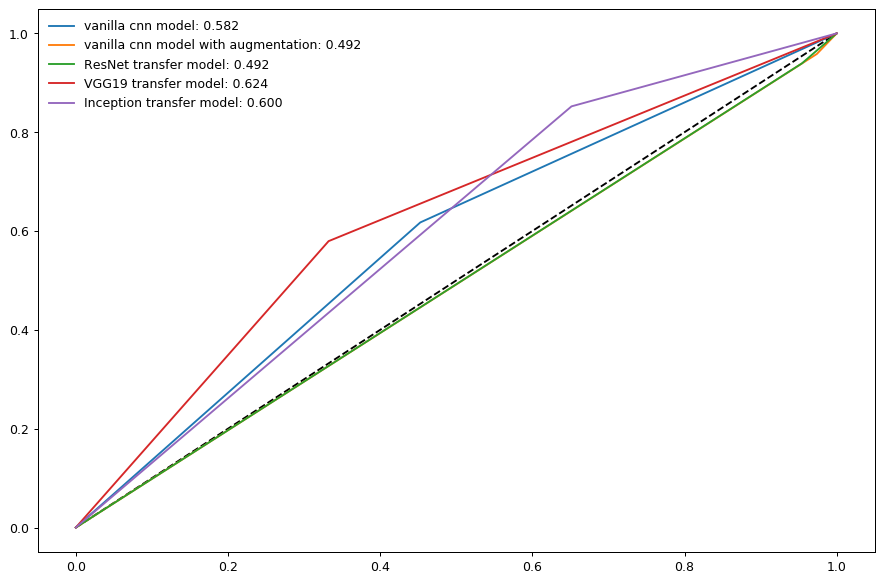

In [17]:
fig = plt.figure(figsize=(12,8), dpi = 90)
plt.plot([0, 1], [0, 1], 'k--')
for model_name, tup in roc_auc_info.items():
    fpr, tpr, auc = tup    
    plt.plot(fpr, tpr, label='{}: {:.3f}'.format(model_name, auc))
plt.legend(frameon=False)
plt.show()